# Tune non-stationary algorithms

Here we create and save the data for tuning of non-stationary algorithms.
For tuning we use a subset (5000 points) of data similar to that used in experiment 7. But the costs don't change
in the tuning region. Saeed said it's the correct way to do tuning.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 4)

In [15]:
all_contexts

array([[1, 1, 1, 2],
       [1, 1, 1, 3],
       [1, 1, 1, 1],
       ...,
       [4, 3, 2, 2],
       [4, 3, 2, 3],
       [4, 3, 2, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [18]:
# Drop arms with small rewards

In [19]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [20]:
y[y == 2] = 4

In [21]:
y[y == 3] = 4

In [22]:
y.value_counts()

4    4596
1    4320
5    4044
Name: final evaluation, dtype: int64

In [23]:
np.sum(np.where(y == 3, 1, 0))

0

In [24]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [25]:
all_rewards

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [26]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4596, 4044])

In [27]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [28]:
all_rewards.shape[0]

12960

In [29]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, 12960),
]

In [30]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [31]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 11000, 12960]

In [32]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.33333333, 0.35462963, 0.31203704])

In [33]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [34]:
new_contexts.shape, new_rewards.shape

((12960, 4), (12960, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.0
Min expected reward for arm 3: 0.0


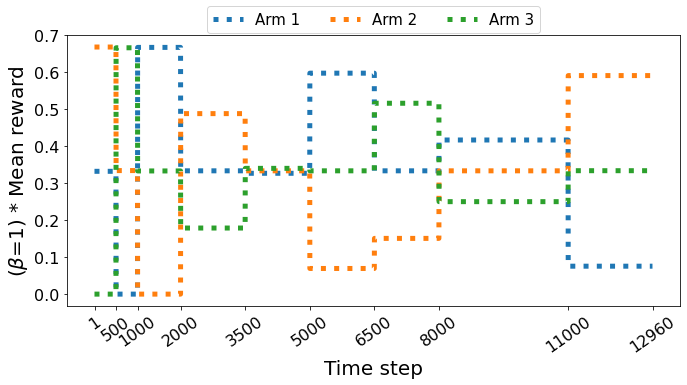

In [35]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Non-stationarity in costs

In [36]:
cost_change_points = [5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [37]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [38]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317]),
 array([0.01312037, 0.01311989, 0.01116167, 0.02732352]),
 array([0.0220223 , 0.02416145, 0.01041169, 0.0293982 ]),
 array([0.02664885, 0.01424678, 0.0136365 , 0.01366809]),
 array([0.01608484, 0.02049513, 0.0186389 , 0.01582458])]

In [39]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [40]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

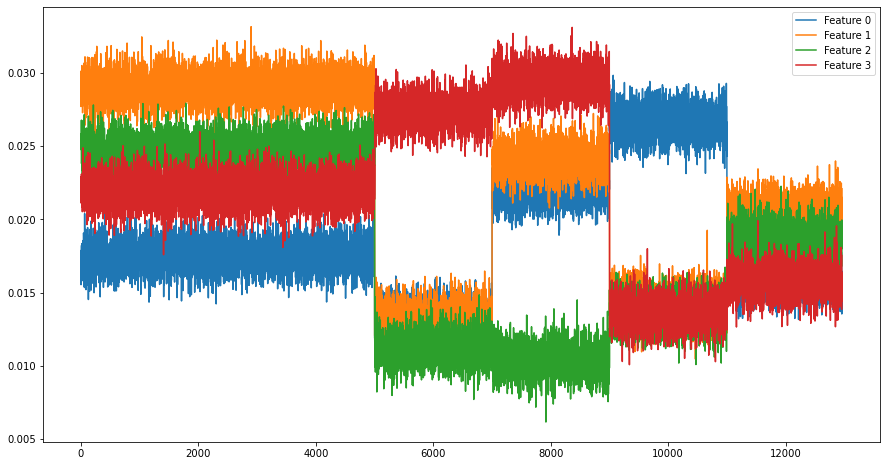

In [41]:
plot_costs(get_costs(), new_contexts.shape[0])

In [42]:
costs_obj = get_costs()

In [43]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [44]:
costs_vector.shape

(12960, 4)

## Plot expected reward minus sum of costs

In [45]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.09861353396213239
Min expected gain for arm 2: -0.09937642273006636
Min expected gain for arm 3: -0.09918037079835809


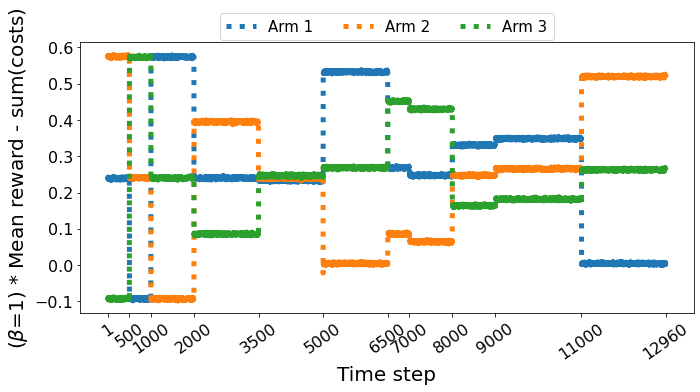

In [46]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [47]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = all_change_point_values
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Save the data

In [48]:
data = (new_contexts, new_rewards, costs_vector)

In [49]:
import pickle

with open('dataset/nursery/nursery_preprocessed.pickle', 'wb') as f:
    pickle.dump(data, f)

## Tuning

In [50]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [51]:
np.random.seed(42)

### PS-LinUCB

In [52]:
ps_linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for omega in [100, 300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
            for i in range(NUM_REPETITIONS):

                ps_linucb = algorithms.PSLinUCB(
                    n_trials=TUNING_NUM_OF_TRIALS,
                    context_dimension=new_contexts.shape[1],
                    n_arms=new_rewards.shape[1],
                    alpha=alpha,
                    omega=omega,
                    delta=delta,
                )


                gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                    ps_linucb,
                    new_contexts,
                    new_rewards,
                    costs_vector,
                    beta=BETA,
                    stop_after=TUNING_NUM_OF_TRIALS,
                )
                change_points = ps_linucb.change_points
                gains[i, :] = gain_pslinucb

            gain_pslinucb = np.mean(gains, axis=0)
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 3004.308296172825
	Total reward: 3470.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 3004.308296172825
	Total reward: 3470.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 3004.308296172825
	Total reward: 3470.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 3004.308296172825
	Total reward: 3470.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 3004.308296172825
	Total reward: 3470.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, delta=0.005)
Beta = 1
Total gain: 2827.3082961728287
	Total reward: 3293.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, delta

PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 2052.3082961728255
	Total reward: 2518.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 2052.3082961728255
	Total reward: 2518.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 2052.3082961728255
	Total reward: 2518.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=300, delta=

PSLinUCB (alpha=0.001, omega=500, delta=0.05)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1826.3082961728294
	Total reward: 2292.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=500, delta=0.15)

PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1550.3082961728305
	Total reward: 2016.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1550.3082961728305
	Total reward: 2016.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1550.3082961728305
	Total reward: 2016.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1550.3082961728305
	Total reward: 2016.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1000, delta=0

PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, del

PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1500, delta=

PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1750, delta=0.

PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 3033.3082961728255
	Total reward: 3499.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 2864.308296172829
	Total reward: 3330.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 2864.308296172829
	Total reward: 3330.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 2864.308296172829
	Total reward: 3330.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 2864.308296172829
	Total reward: 3330.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 2864.308296172829
	Total reward: 3330.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=100, delta

PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 2050.3082961728255
	Total reward: 2516.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=300, delta=

PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1835.3082961728294
	Total reward: 2301.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1835.3082961728294
	Total reward: 2301.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 1862.3082961728294
	Total reward: 2328.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 1862.3082961728294
	Total reward: 2328.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 1862.3082961728294
	Total reward: 2328.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 1862.3082961728294
	Total reward: 2328.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=500, delta=0.

PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1000, delta=0.005)
Beta = 1
Total gain: 1343.308296172831
	Total reward: 1809.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=1000,

PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 1280.308296172829
	Total reward: 1746.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta

PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1522.308296172829
	Total reward: 1988.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.15

PSLinUCB (alpha=0.005, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=1750, delta=0.2)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=2000, delta=0

PSLinUCB (alpha=0.01, omega=100, delta=0.005)
Beta = 1
Total gain: 3037.308296172827
	Total reward: 3503.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.005)
Beta = 1
Total gain: 3037.308296172827
	Total reward: 3503.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 2885.308296172829
	Total reward: 3351.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 2885.308296172829
	Total reward: 3351.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 2885.308296172829
	Total reward: 3351.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 2885.308296172829
	Total reward: 3351.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta 

PSLinUCB (alpha=0.01, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=300, delta=0.05)
Beta = 1
Total gain: 2077.3082961728255
	Total reward: 2543.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 2046.3082961728257
	Total reward: 2512.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Bet

PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta = 1
Total gain: 1857.3082961728294
	Total reward: 2323.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta = 1
Total gain: 1857.3082961728294
	Total reward: 2323.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta = 1
Total gain: 1857.3082961728294
	Total reward: 2323.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta = 1
Total gain: 1868.3082961728294
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta = 1
Total gain: 1868.3082961728294
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta = 1
Total gain: 1868.3082961728294
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta 

PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.005)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.005)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.005)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.005)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1000, delta=0.005)
Beta = 1
Total gain: 1344.308296172831
	Total reward: 1810.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=

PSLinUCB (alpha=0.01, omega=1250, delta=0.03)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.03)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1250, delta=0.03)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1250, delta=0.03)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.05)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1250, delta=0.05)
Beta = 1
Total gain: 1402.308296172829
	Total reward: 1868.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1250, delta=0.05)


PSLinUCB (alpha=0.01, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.01, omega=1500, delta=0.1)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=1500, delta=0.15)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.15)
Be

PSLinUCB (alpha=0.01, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=2000, delta=0.001)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=2000, delta=0.005)
Beta = 1
Total gain: 1266.308296172829
	Total reward: 1732.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=2000, delta=

PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Beta = 1
Total gain: 2804.3082961728282
	Total reward: 3270.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Beta = 1
Total gain: 2804.3082961728282
	Total reward: 3270.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Beta = 1
Total gain: 2804.3082961728282
	Total reward: 3270.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.03)
Beta = 1
Total gain: 2844.308296172829
	Total reward: 3310.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.03)
Beta = 1
Total gain: 2844.308296172829
	Total reward: 3310.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.03)
Beta = 1
Total gain: 2844.308296172829
	Total reward: 3310.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=100, delta=0.03)
Beta

PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 2003.3082961728269
	Total reward: 2469.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.1)
Beta = 1
Total gain: 1864.3082961728262
	Total reward: 2330.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.1)
Beta = 1
Total gain: 1864.3082961728262
	Total reward: 2330.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=300, delta=0.1)
Beta = 1
Total gain: 1864.3082961728262
	Total reward: 2330.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=300, delta=0.1)
Beta = 1
Total gain: 1864.3082961728262
	Total reward: 2330.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=300, delta=0.1)
Beta = 1
Total gain: 1864.3082961728262
	Total reward: 2330.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=300, delta=0.15)
Beta =

PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1
Total gain: 1521.3082961728308
	Total reward: 1987.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1
Total gain: 1521.3082961728308
	Total reward: 1987.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1
Total gain: 1521.3082961728308
	Total reward: 1987.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1
Total gain: 1521.3082961728308
	Total reward: 1987.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=750, delta=0.001)
Beta = 1
Total gain: 1688.3082961728292
	Total reward: 2154.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=750, delta=0.001)
Beta = 1
Total gain: 1688.3082961728292
	Total reward: 2154.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=750, delta=0.001)
Be

PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.01)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.01)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.01)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.01)
Beta = 1
Total gain: 1282.30829617283
	Total reward: 1748.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.01)
Beta

PSLinUCB (alpha=0.05, omega=1250, delta=0.05)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=1250, delta=0.05)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=1250, delta=0.05)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1250, delta=0.05)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1250, delta=0.05)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=1250, delta=0.1)
Beta = 1
Total gain: 1230.3082961728298
	Total reward: 1696.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1250, delta=0

PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1500, delta=0.2)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1500, delta=0.2)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1500, delta=0.2)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1500, delta=0.2

PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.005)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.005)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.005)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.005)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.005)
Beta = 1
Total gain: 1458.3082961728298
	Total reward: 1924.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=2000, 

PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1
Total gain: 3170.308296172825
	Total reward: 3636.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1
Total gain: 3170.308296172825
	Total reward: 3636.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1
Total gain: 3170.308296172825
	Total reward: 3636.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1
Total gain: 3170.308296172825
	Total reward: 3636.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=100, delta=0.05)
Beta = 1
Total gain: 2968.3082961728296
	Total reward: 3434.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=100, delta=0.05)
Beta = 1
Total gain: 2968.3082961728296
	Total reward: 3434.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=100, delta=0.05)
Beta = 1
Tot

PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 2187.3082961728264
	Total reward: 2653.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 2187.3082961728264
	Total reward: 2653.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Beta = 1
Total gain: 2139.308296172825
	Total reward: 2605.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Beta = 1
Total gain: 2139.308296172825
	Total reward: 2605.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Beta = 1
Total gain: 2139.308296172825
	Total reward: 2605.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Beta = 1
Total gain: 2139.308296172825
	Total reward: 2605.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.15)
Beta = 1
Total

PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.005)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.005)
Beta = 1
Total gain: 1724.30829617283
	Total reward: 2190.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.005)
Beta = 1
Tota

PSLinUCB (alpha=0.1, omega=1000, delta=0.01)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.03)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1000, delta=0.03)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.03)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.03)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1000, delta=0.03)
Beta = 1
Total gain: 1341.3082961728296
	Total reward: 1807.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.05)
B

PSLinUCB (alpha=0.1, omega=1250, delta=0.1)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1250, delta=0.1)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1250, delta=0.1)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1250, delta=0.1)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1250, delta=0.15)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1250, delta=0.15)
Beta = 1
Total gain: 1386.3082961728296
	Total reward: 1852.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1250, delta=0.15)
Beta 

PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001

PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.01)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=2000, delta=0.03)
Beta = 1
Total gain: 1506.3082961728296
	Total reward: 1972.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.03)
B

PSLinUCB (alpha=0.2, omega=100, delta=0.05)
Beta = 1
Total gain: 3026.3082961728255
	Total reward: 3492.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=100, delta=0.05)
Beta = 1
Total gain: 3026.3082961728255
	Total reward: 3492.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=100, delta=0.05)
Beta = 1
Total gain: 3026.3082961728255
	Total reward: 3492.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=100, delta=0.1)
Beta = 1
Total gain: 3119.308296172826
	Total reward: 3585.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=100, delta=0.1)
Beta = 1
Total gain: 3119.308296172826
	Total reward: 3585.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=100, delta=0.1)
Beta = 1
Total gain: 3119.308296172826
	Total reward: 3585.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=100, delta=0.1)
Beta = 1
Total 

PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
Total gain: 1939.3082961728262
	Total reward: 2405.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=300, delta=0.2)
Beta = 1
Total gain: 2086.308296172826
	Total reward: 2552.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=300, delta=0.2)
Beta = 1
Total gain: 2086.308296172826
	Total reward: 2552.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.2)
Beta = 1
Total gain: 2086.308296172826
	Total reward: 2552.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.2)
Beta = 1
Total gain: 2086.308296172826
	Total reward: 2552.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.2)
Beta = 1
Total gain: 2086.308296172826
	Total reward: 2552.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=500, delta=0.001)
Beta = 1
Total ga

PSLinUCB (alpha=0.2, omega=750, delta=0.005)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=750, delta=0.005)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.005)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.01)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.01)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.01)
Beta = 1
Total gain: 1754.30829617283
	Total reward: 2220.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=750, delta=0.01)
Beta = 1
Total ga

PSLinUCB (alpha=0.2, omega=1000, delta=0.05)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1000, delta=0.05)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1000, delta=0.05)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1000, delta=0.05)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1000, delta=0.05)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1000, delta=0.1)
Beta = 1
Total gain: 1657.3082961728298
	Total reward: 2123.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1000, delta=0.1)
Bet

PSLinUCB (alpha=0.2, omega=1250, delta=0.15)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.15)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.15)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.2)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.2)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.2)
Beta = 1
Total gain: 1556.3082961728298
	Total reward: 2022.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1250, delta=0.2)
Beta 

PSLinUCB (alpha=0.2, omega=1750, delta=0.001)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1750, delta=0.005)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.2, omega=1750, delta=0

PSLinUCB (alpha=0.2, omega=2000, delta=0.03)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.03)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=2000, delta=0.03)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=2000, delta=0.03)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.05)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.05)
Beta = 1
Total gain: 1514.3082961728298
	Total reward: 1980.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.05)
B

PSLinUCB (alpha=0.3, omega=100, delta=0.1)
Beta = 1
Total gain: 3009.3082961728305
	Total reward: 3475.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=100, delta=0.1)
Beta = 1
Total gain: 3009.3082961728305
	Total reward: 3475.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=100, delta=0.15)
Beta = 1
Total gain: 3236.308296172827
	Total reward: 3702.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=100, delta=0.15)
Beta = 1
Total gain: 3236.308296172827
	Total reward: 3702.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=100, delta=0.15)
Beta = 1
Total gain: 3236.308296172827
	Total reward: 3702.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.15)
Beta = 1
Total gain: 3236.308296172827
	Total reward: 3702.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=100, delta=0.15)
Beta = 1
Total

PSLinUCB (alpha=0.3, omega=500, delta=0.001)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.001)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.001)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.001)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.005)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.005)
Beta = 1
Total gain: 2062.3082961728264
	Total reward: 2528.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=500, delta=0.005)
B

PSLinUCB (alpha=0.3, omega=750, delta=0.01)
Beta = 1
Total gain: 1907.308296172826
	Total reward: 2373.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Beta = 1
Total gain: 1918.308296172826
	Total reward: 2384.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Beta = 1
Total gain: 1918.308296172826
	Total reward: 2384.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Beta = 1
Total gain: 1918.308296172826
	Total reward: 2384.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Beta = 1
Total gain: 1918.308296172826
	Total reward: 2384.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Beta = 1
Total gain: 1918.308296172826
	Total reward: 2384.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.3, omega=750, delta=0.05)
Beta = 1
Total

PSLinUCB (alpha=0.3, omega=1000, delta=0.1)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.3, omega=1000, delta=0.1)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1000, delta=0.1)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.3, omega=1000, delta=0.15)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1000, delta=0.15)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1000, delta=0.15)
Beta = 1
Total gain: 1882.308296172826
	Total reward: 2348.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1000, delta=0.15)
Beta = 1
T

PSLinUCB (alpha=0.3, omega=1250, delta=0.2)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1500, delta=0.001)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1500, delta=0.005)
Be

PSLinUCB (alpha=0.3, omega=1750, delta=0.01)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1750, delta=0.01)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=1750, delta=0.01)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1750, delta=0.01)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1750, delta=0.03)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1750, delta=0.03)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=1750, delta=0.03)
Beta = 

PSLinUCB (alpha=0.3, omega=2000, delta=0.05)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=2000, delta=0.05)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.3, omega=2000, delta=0.1)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 1.2s
PSLinUCB (alpha=0.3, omega=2000, delta=0.1)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=2000, delta=0.1)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=2000, delta=0.1)
Beta = 1
Total gain: 1725.308296172826
	Total reward: 2191.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=2000, delta=0.1)
Beta = 1
Tot

PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Beta = 1
Total gain: 3167.3082961728273
	Total reward: 3633.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Beta = 1
Total gain: 3167.3082961728273
	Total reward: 3633.0
	Total cost: 465.6917038271713
Execution time: 1.3s
PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Beta = 1
Total gain: 3167.3082961728273
	Total reward: 3633.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Beta = 1
Total gain: 3167.3082961728273
	Total reward: 3633.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Beta = 1
Total gain: 3167.3082961728273
	Total reward: 3633.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.001)
Beta = 1
Total gain: 1937.3082961728262
	Total reward: 2403.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=300, delta=0.001)
Beta = 1
To

PSLinUCB (alpha=0.4, omega=500, delta=0.005)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=500, delta=0.005)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=500, delta=0.005)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=500, delta=0.01)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=500, delta=0.01)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=500, delta=0.01)
Beta = 1
Total gain: 2011.3082961728262
	Total reward: 2477.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=500, delta=0.01)
Beta 

PSLinUCB (alpha=0.4, omega=750, delta=0.03)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Beta = 1
Total gain: 1808.3082961728262
	Total reward: 2274.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=750, delta=0.1)
Beta = 1


PSLinUCB (alpha=0.4, omega=1000, delta=0.15)
Beta = 1
Total gain: 2122.3082961728246
	Total reward: 2588.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1000, delta=0.15)
Beta = 1
Total gain: 2122.3082961728246
	Total reward: 2588.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1000, delta=0.15)
Beta = 1
Total gain: 2122.3082961728246
	Total reward: 2588.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=1000, delta=0.15)
Beta = 1
Total gain: 2122.3082961728246
	Total reward: 2588.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1000, delta=0.2)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.4, omega=1000, delta=0.2)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 1.4s
PSLinUCB (alpha=0.4, omega=1000, delta=0.2)
Beta

PSLinUCB (alpha=0.4, omega=1500, delta=0.001)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=1500, delta=0.001)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=1500, delta=0.005)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=1500, delta=0.005)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=1500, delta=0.005)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=1500, delta=0.005)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=1500, delta=0

PSLinUCB (alpha=0.4, omega=1750, delta=0.03)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1750, delta=0.03)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1750, delta=0.03)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1750, delta=0.03)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1750, delta=0.03)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.05)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=1750, delta=0.05)
B

PSLinUCB (alpha=0.4, omega=2000, delta=0.1)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=2000, delta=0.1)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=2000, delta=0.1)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.15)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=2000, delta=0.15)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=2000, delta=0.15)
Beta = 1
Total gain: 1954.3082961728262
	Total reward: 2420.0
	Total cost: 465.6917038271713
Execution time: 1.3s
PSLinUCB (alpha=0.4, omega=2000, delta=0.15)
Beta

PSLinUCB (alpha=0.5, omega=300, delta=0.001)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=300, delta=0.001)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=300, delta=0.001)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=300, delta=0.001)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=300, delta=0.001)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=300, delta=0.005)
Beta = 1
Total gain: 2119.308296172824
	Total reward: 2585.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=300, delta=0.005)
Beta = 

PSLinUCB (alpha=0.5, omega=500, delta=0.01)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=500, delta=0.01)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=500, delta=0.03)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=500, delta=0.03)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=500, delta=0.03)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=500, delta=0.03)
Beta = 1
Total gain: 2070.308296172825
	Total reward: 2536.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=500, delta=0.03)
Beta = 1
Total

PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.15)
Beta = 1
Total gain: 1958.3082961728257
	Total reward: 2424.0
	Total cost: 465.6917038271713
Execution time: 1.1s
PSLinUCB (alpha=0.5, omega=750, delta=0.15)
Beta = 1
Tota

PSLinUCB (alpha=0.5, omega=1000, delta=0.2)
Beta = 1
Total gain: 1898.3082961728257
	Total reward: 2364.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1000, delta=0.2)
Beta = 1
Total gain: 1898.3082961728257
	Total reward: 2364.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1000, delta=0.2)
Beta = 1
Total gain: 1898.3082961728257
	Total reward: 2364.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.001)
Beta = 1
Total gain: 2095.3082961728255
	Total reward: 2561.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.001)
Beta = 1
Total gain: 2095.3082961728255
	Total reward: 2561.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.001)
Beta = 1
Total gain: 2095.3082961728255
	Total reward: 2561.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.001)


PSLinUCB (alpha=0.5, omega=1500, delta=0.005)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.9s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=1500, delta=0.03)


PSLinUCB (alpha=0.5, omega=1750, delta=0.05)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.05)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.05)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.05)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.1)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.1)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.1)
Beta

PSLinUCB (alpha=0.5, omega=2000, delta=0.15)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=2000, delta=0.15)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=2000, delta=0.2)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=2000, delta=0.2)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=2000, delta=0.2)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=2000, delta=0.2)
Beta = 1
Total gain: 1868.3082961728257
	Total reward: 2334.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=2000, delta=0.2)
Beta =

PSLinUCB (alpha=0.6, omega=300, delta=0.005)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=300, delta=0.005)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=300, delta=0.005)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=300, delta=0.005)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=300, delta=0.005)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=300, delta=0.01)
Beta = 1
Total gain: 2240.308296172827
	Total reward: 2706.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=300, delta=0.01)
Beta = 1


PSLinUCB (alpha=0.6, omega=500, delta=0.03)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=500, delta=0.03)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=500, delta=0.03)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 1.2s
PSLinUCB (alpha=0.6, omega=500, delta=0.05)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.6, omega=500, delta=0.05)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=500, delta=0.05)
Beta = 1
Total gain: 1956.3082961728269
	Total reward: 2422.0
	Total cost: 465.6917038271713
Execution time: 1.5s
PSLinUCB (alpha=0.6, omega=500, delta=0.05)
Beta = 1

PSLinUCB (alpha=0.6, omega=750, delta=0.1)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 1.0s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Beta = 1
Total gain: 2053.3082961728264
	Total reward: 2519.0
	Total cost: 465.6917038271713
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=750, delta=0.2)
Beta = 1
T

PSLinUCB (alpha=0.6, omega=1250, delta=0.001)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0.001)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0.001)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0.001)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0.005)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0.005)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1250, delta=0

PSLinUCB (alpha=0.6, omega=1500, delta=0.01)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.01)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.03)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.03)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.03)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.03)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.03)
B

PSLinUCB (alpha=0.6, omega=1750, delta=0.1)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.1)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.1)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.1)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.1)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.15)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1750, delta=0.15)
Beta =

PSLinUCB (alpha=0.6, omega=2000, delta=0.2)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=2000, delta=0.2)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=2000, delta=0.2)
Beta = 1
Total gain: 2200.3082961728282
	Total reward: 2666.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.001)
Beta = 1
Total gain: 3174.3082961728273
	Total reward: 3640.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.001)
Beta = 1
Total gain: 3174.3082961728273
	Total reward: 3640.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.001)
Beta = 1
Total gain: 3174.3082961728273
	Total reward: 3640.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.001)
Beta

PSLinUCB (alpha=0.7, omega=300, delta=0.005)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.01)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.01)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=300, delta=0.01)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.01)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=300, delta=0.01)
Beta = 1
Total gain: 2100.308296172824
	Total reward: 2566.0
	Total cost: 465.6917038271713
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=300, delta=0.03)
Beta = 1
Tota

PSLinUCB (alpha=0.7, omega=500, delta=0.05)
Beta = 1
Total gain: 2436.308296172831
	Total reward: 2902.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.05)
Beta = 1
Total gain: 2436.308296172831
	Total reward: 2902.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.1)
Beta = 1
Total gain: 2376.3082961728323
	Total reward: 2842.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=500, delta=0.1)
Beta = 1
Total gain: 2376.3082961728323
	Total reward: 2842.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=500, delta=0.1)
Beta = 1
Total gain: 2376.3082961728323
	Total reward: 2842.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=500, delta=0.1)
Beta = 1
Total gain: 2376.3082961728323
	Total reward: 2842.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=500, delta=0.1)
Beta = 1
Total 

PSLinUCB (alpha=0.7, omega=750, delta=0.2)
Beta = 1
Total gain: 2171.308296172827
	Total reward: 2637.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=750, delta=0.2)
Beta = 1
Total gain: 2171.308296172827
	Total reward: 2637.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=750, delta=0.2)
Beta = 1
Total gain: 2171.308296172827
	Total reward: 2637.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=750, delta=0.2)
Beta = 1
Total gain: 2171.308296172827
	Total reward: 2637.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.001)
Beta = 1
Total gain: 2515.308296172831
	Total reward: 2981.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.001)
Beta = 1
Total gain: 2515.308296172831
	Total reward: 2981.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.001)
Beta = 1
Tot

PSLinUCB (alpha=0.7, omega=1250, delta=0.005)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.005)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.01)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.01)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.01)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.01)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.01)
Beta 

PSLinUCB (alpha=0.7, omega=1500, delta=0.05)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.05)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.05)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.05)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.1)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.1)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.1)
Beta = 1
T

PSLinUCB (alpha=0.7, omega=1750, delta=0.15)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.15)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.2)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.2)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.2)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.2)
Beta = 1
Total gain: 2450.308296172831
	Total reward: 2916.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.2)
Beta = 1
Tot

PSLinUCB (alpha=0.8, omega=100, delta=0.005)
Beta = 1
Total gain: 3214.308296172828
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.005)
Beta = 1
Total gain: 3214.308296172828
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.005)
Beta = 1
Total gain: 3214.308296172828
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.005)
Beta = 1
Total gain: 3214.308296172828
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.005)
Beta = 1
Total gain: 3214.308296172828
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.01)
Beta = 1
Total gain: 3214.3082961728273
	Total reward: 3680.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=100, delta=0.01)
Beta = 1

PSLinUCB (alpha=0.8, omega=300, delta=0.03)
Beta = 1
Total gain: 2477.30829617283
	Total reward: 2943.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.05)
Beta = 1
Total gain: 2428.3082961728314
	Total reward: 2894.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.05)
Beta = 1
Total gain: 2428.3082961728314
	Total reward: 2894.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.05)
Beta = 1
Total gain: 2428.3082961728314
	Total reward: 2894.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.05)
Beta = 1
Total gain: 2428.3082961728314
	Total reward: 2894.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.05)
Beta = 1
Total gain: 2428.3082961728314
	Total reward: 2894.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.1)
Beta = 1
To

PSLinUCB (alpha=0.8, omega=500, delta=0.15)
Beta = 1
Total gain: 2614.3082961728287
	Total reward: 3080.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.15)
Beta = 1
Total gain: 2614.3082961728287
	Total reward: 3080.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.15)
Beta = 1
Total gain: 2614.3082961728287
	Total reward: 3080.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.2)
Beta = 1
Total gain: 2468.308296172829
	Total reward: 2934.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.2)
Beta = 1
Total gain: 2468.308296172829
	Total reward: 2934.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.2)
Beta = 1
Total gain: 2468.308296172829
	Total reward: 2934.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=500, delta=0.2)
Beta = 1
Total 

PSLinUCB (alpha=0.8, omega=1000, delta=0.005)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.005)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.005)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.005)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.005)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.01)
Beta = 1
Total gain: 2754.3082961728296
	Total reward: 3220.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1000, delta=0.

PSLinUCB (alpha=0.8, omega=1250, delta=0.03)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.03)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.05)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.05)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.05)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.05)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.05)
B

PSLinUCB (alpha=0.8, omega=1500, delta=0.15)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.15)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.15)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.15)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.15)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.2)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.2)
Bet

PSLinUCB (alpha=0.8, omega=2000, delta=0.001)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0.001)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0.001)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0.005)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0.005)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0.005)
Beta = 1
Total gain: 2721.3082961728296
	Total reward: 3187.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=2000, delta=0

PSLinUCB (alpha=0.9, omega=100, delta=0.01)
Beta = 1
Total gain: 3282.3082961728273
	Total reward: 3748.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.03)
Beta = 1
Total gain: 3281.3082961728282
	Total reward: 3747.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.03)
Beta = 1
Total gain: 3281.3082961728282
	Total reward: 3747.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.03)
Beta = 1
Total gain: 3281.3082961728282
	Total reward: 3747.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.03)
Beta = 1
Total gain: 3281.3082961728282
	Total reward: 3747.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.03)
Beta = 1
Total gain: 3281.3082961728282
	Total reward: 3747.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1

PSLinUCB (alpha=0.9, omega=300, delta=0.1)
Beta = 1
Total gain: 2831.308296172827
	Total reward: 3297.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.1)
Beta = 1
Total gain: 2831.308296172827
	Total reward: 3297.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.1)
Beta = 1
Total gain: 2831.308296172827
	Total reward: 3297.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.1)
Beta = 1
Total gain: 2831.308296172827
	Total reward: 3297.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.15)
Beta = 1
Total gain: 2546.30829617283
	Total reward: 3012.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.9, omega=300, delta=0.15)
Beta = 1
Total gain: 2546.30829617283
	Total reward: 3012.0
	Total cost: 465.6917038271713
Execution time: 0.3s
PSLinUCB (alpha=0.9, omega=300, delta=0.15)
Beta = 1
Total gain:

PSLinUCB (alpha=0.9, omega=500, delta=0.2)
Beta = 1
Total gain: 2463.3082961728296
	Total reward: 2929.0
	Total cost: 465.6917038271713
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=750, delta=0.001)
Beta = 1
Total gain: 2392.308296172828
	Total reward: 2858.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=750, delta=0.001)
Beta = 1
Total gain: 2392.308296172828
	Total reward: 2858.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=750, delta=0.001)
Beta = 1
Total gain: 2392.308296172828
	Total reward: 2858.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=750, delta=0.001)
Beta = 1
Total gain: 2392.308296172828
	Total reward: 2858.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=750, delta=0.001)
Beta = 1
Total gain: 2392.308296172828
	Total reward: 2858.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=750, delta=0.005)
Beta = 1

PSLinUCB (alpha=0.9, omega=1000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.03)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.03)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.03)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.03)
B

PSLinUCB (alpha=0.9, omega=1250, delta=0.05)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.1)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.1)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.1)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.1)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.1)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.15)
Beta =

PSLinUCB (alpha=0.9, omega=1500, delta=0.2)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.2)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.2)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.2)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.001)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.001)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.001)
Be

PSLinUCB (alpha=0.9, omega=2000, delta=0.005)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.01)
Beta = 1
Total gain: 2854.3082961728305
	Total reward: 3320.0
	Total cost: 465.6917038271713
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=2000, delta=0.03)


In [53]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.5, 100, 0.1)

### Evaluate tuned

In [54]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_ps_linucb,
        omega=best_omega_ps_linucb,
        delta=best_delta_ps_linucb,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8151.318871688177
	Total reward: 9194.0
	Total cost: 1042.681128311835
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8151.318871688177
	Total reward: 9194.0
	Total cost: 1042.681128311835
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8151.318871688177
	Total reward: 9194.0
	Total cost: 1042.681128311835
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8151.318871688177
	Total reward: 9194.0
	Total cost: 1042.681128311835
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8151.318871688177
	Total reward: 9194.0
	Total cost: 1042.681128311835
Execution time: 0.8s
Average gain: 8151.318871688176


### Algorithm1 is tuned separately

Using script3 in cloud. This is because Algorithm1 is much more computationally demanding.

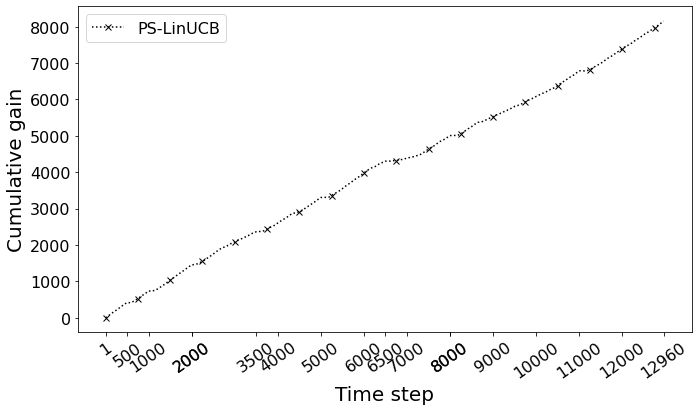

In [55]:
plot_gains({
    'PS-LinUCB': gain_pslinucb,
},
)
